In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import logging

## Loading data

In [20]:
DATA_PATH = '../data/raw/'

dronerf_path = os.path.join(DATA_PATH, 'dronerf')
export_path = '../data/processed/auto_input'
os.makedirs(export_path, exist_ok=True)

name_map = {
    'AR drone': 'ar',
    'Bepop drone': 'bepop',
    'Background RF activities': 'bg',
    'Phantom drone': 'phantom'
}

sample_rate = 40e6
img_dim = 224

In [3]:
def create_spectrogram(file_path, export_path, sample_rate):
    data = pd.read_csv(file_path, header=None).values.flatten()
    data = data[0::2] + 1j * data[1::2]

    mpl_specgram_window = plt.mlab.window_hanning(np.ones(1024))

    f, t, Sxx = signal.spectrogram(data, sample_rate, detrend=False, nfft = 1024, window = mpl_specgram_window, return_onesided=False)
    Sxx_db = 10*np.log10(Sxx)

    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)
    plt.imshow(Sxx_db, interpolation=None, aspect='auto')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(export_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    with Image.open(export_path) as img:
        print(f"Image shape for {os.path.basename(export_path)}: {img.size}")

## Converting into spectrograms

In [4]:
from scipy import signal
def compute_spectrogram(file_path, sample_rate):
    data = pd.read_csv(file_path, header=None).values.flatten()
    data = data[0::2] + 1j * data[1::2]

    mpl_specgram_window = plt.mlab.window_hanning(np.ones(1024))

    f, t, Sxx = signal.spectrogram(data, sample_rate, detrend=False, nfft = 1024, window = mpl_specgram_window, return_onesided=False)
    Sxx_db = 10*np.log10(np.abs(Sxx))
    
    return f, t, Sxx_db

In [5]:
def save_ml_spectrogram(f, t, Sxx_db, filename, img_size=(224, 224)):
    Sxx_norm = ((Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min()) * 255).astype(np.uint8)
    
    img = Image.fromarray(Sxx_norm)
    img = img.resize(img_size)
    img.save(filename)

    with Image.open(filename) as img:
        print(f"Image shape for {os.path.basename(filename)}: {img.size}")

In [6]:
def save_readable_spectrogram(f, t, Sxx_db, filename, sample_rate):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    im = ax.imshow(Sxx_db, aspect='auto', origin='lower', 
                   extent=[t.min(), t.max(), -sample_rate/2, sample_rate/2],
                   cmap='viridis')
    
    # Add colorbar
    cbar = fig.colorbar(im)
    cbar.set_label('Power/Frequency (dB/Hz)')
    
    # Set frequency ticks
    freq_range = sample_rate / 2  # Nyquist frequency
    freq_ticks = np.linspace(-freq_range, freq_range, 9)
    freq_labels = [f'{freq/1e6:.1f}' for freq in freq_ticks]
    ax.set_yticks(freq_ticks)
    ax.set_yticklabels(freq_labels)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title('Spectrogram')
    
    # Save figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close(fig)

In [7]:
def process_file(file_path, sample_rate, ml_output_folder, readable_output_folder):
    f, t, Sxx_db = compute_spectrogram(file_path, sample_rate)

    base_name = os.path.splitext(os.path.basename(file_path))[0]
    ml_filename = os.path.join(ml_output_folder, f"{base_name}.png")
    readable_filename = os.path.join(readable_output_folder, f"{base_name}_readable.png")

    save_ml_spectrogram(f, t, Sxx_db, ml_filename)
    
    save_readable_spectrogram(f, t, Sxx_db, readable_filename, sample_rate)

In [8]:
for drone_folder in os.listdir(dronerf_path):
    drone_path = os.path.join(dronerf_path, drone_folder)
    if not os.path.isdir(drone_path):
        continue
    
    drone = name_map.get(drone_folder)
    if drone is None:
        print(f"Warning: Unknown drone folder '{drone_folder}'. Skipping.")
        continue
        
    ml_output_folder = os.path.join(export_path, drone, 'ml')
    readable_output_folder = os.path.join(export_path, drone, 'readable')
    os.makedirs(ml_output_folder, exist_ok=True)
    os.makedirs(readable_output_folder, exist_ok=True)
    
    lower_path = os.path.join(drone_path, 'lower')
    for filename in os.listdir(lower_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(lower_path, filename)
            process_file(file_path, sample_rate, ml_output_folder, readable_output_folder)

Image shape for 00000L_28.png: (224, 224)
Image shape for 00000L_14.png: (224, 224)
Image shape for 00000L_15.png: (224, 224)
Image shape for 00000L_29.png: (224, 224)
Image shape for 00000L_17.png: (224, 224)
Image shape for 00000L_16.png: (224, 224)
Image shape for 00000L_12.png: (224, 224)
Image shape for 00000L_13.png: (224, 224)
Image shape for 00000L_11.png: (224, 224)
Image shape for 00000L_39.png: (224, 224)
Image shape for 00000L_38.png: (224, 224)
Image shape for 00000L_10.png: (224, 224)
Image shape for 00000L_5.png: (224, 224)
Image shape for 00000L_4.png: (224, 224)
Image shape for 00000L_6.png: (224, 224)
Image shape for 00000L_7.png: (224, 224)
Image shape for 00000L_3.png: (224, 224)
Image shape for 00000L_2.png: (224, 224)
Image shape for 00000L_0.png: (224, 224)
Image shape for 00000L_1.png: (224, 224)
Image shape for 00000L_40.png: (224, 224)
Image shape for 00000L_9.png: (224, 224)
Image shape for 00000L_8.png: (224, 224)
Image shape for 00000L_35.png: (224, 224)
Im

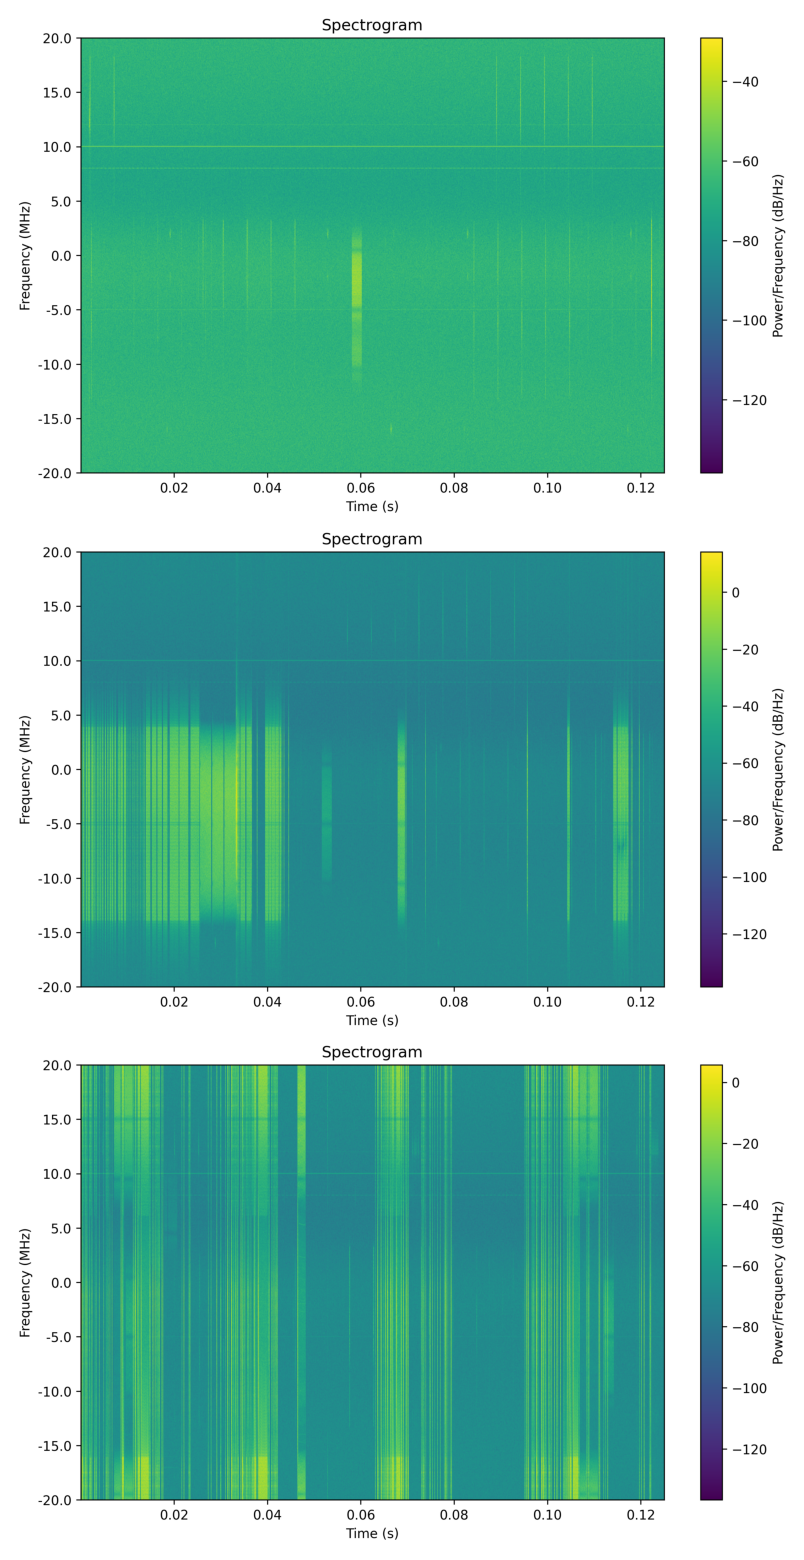

In [18]:
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# read images
bg_spec_img = mpimg.imread(os.path.join(export_path, 'bg/readable/00000L_13_readable.png'))
ar_spec_img = mpimg.imread(os.path.join(export_path, 'ar/readable/10100L_2_readable.png'))
phantom_spec_img = mpimg.imread(os.path.join(export_path, 'phantom/readable/11000L_14_readable.png'))

# display images
fig, ax = plt.subplots(3, 1, figsize=(20, 20))  # Adjust figsize for better sizing

ax[0].imshow(bg_spec_img)
ax[0].axis('off')

ax[1].imshow(ar_spec_img)
ax[1].axis('off') 

ax[2].imshow(phantom_spec_img)
ax[2].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Spectrograms to feature matrix for models

Opens spectrogram images and converts into grayscale (just to make sure). These images are then rotated 270 degrees, min-max normalized, and reshaped to a 1D array. All these flattened images are stacked on top of each other to build our feature matrix.

In [95]:
X_list = []
y = []
label_mapping = {'bg': 0, 'ar': 1, 'phantom': 2}

for drone in ['ar', 'bepop', 'bg', 'phantom']:
    pngs_path = os.path.join(export_path, drone, 'ml')
    if not os.path.exists(pngs_path):
        print(f"Warning: Directory not found: {pngs_path}")
        continue
    
    drone_pngs_path = [os.path.join(pngs_path, f) for f in os.listdir(pngs_path) if f.endswith('.png')]
    
    for png_path in drone_pngs_path:
        img = np.array(Image.open(png_path).convert('L'))
        x = img.reshape(1, img_dim**2)
        X_list.append(x)
        y.append(label_mapping[drone])

X_array = np.array(X_list).reshape(len(X_list), -1)
y_array = np.array(y)

X = pd.DataFrame(X_array, columns=[f'p{i}' for i in range(img_dim ** 2)])
y = pd.DataFrame(y_array, columns=['y'])

In [96]:
from sklearn.preprocessing import StandardScaler

cols = X.columns
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=cols)

In [97]:
X_scaled.head(1)

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p50166,p50167,p50168,p50169,p50170,p50171,p50172,p50173,p50174,p50175
0,-2.012434,-1.901949,-1.986629,-2.048109,-2.078351,-2.158202,-1.988618,-1.979176,-1.990999,-2.151792,...,-1.996117,-1.804393,-1.821423,-1.646414,-1.884819,-1.775319,-1.718977,-1.951573,-1.855035,-1.747837


## PCA

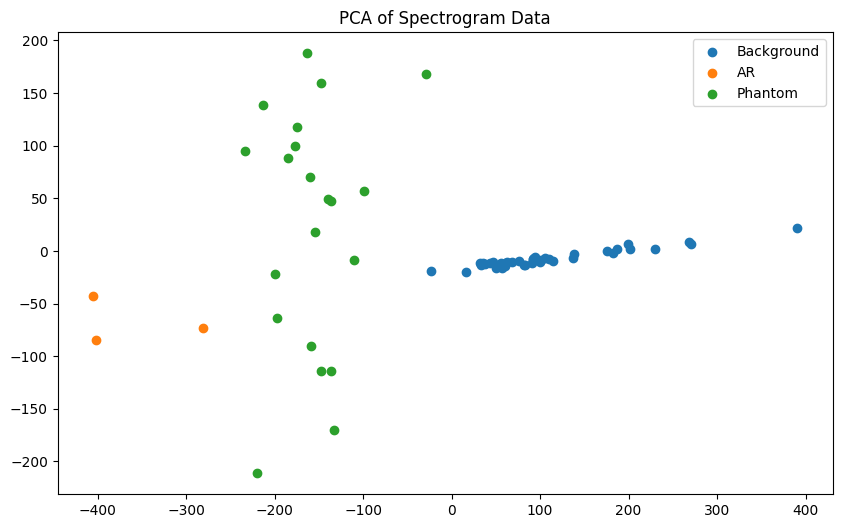

In [98]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y_array == 0, 0], X_pca[y_array == 0, 1], label='Background')
plt.scatter(X_pca[y_array == 1, 0], X_pca[y_array == 1, 1], label='AR')
plt.scatter(X_pca[y_array == 2, 0], X_pca[y_array == 2, 1], label='Phantom')
plt.legend()
plt.title('PCA of Spectrogram Data')
plt.show()

## Split data into training and testing

For anomaly detection cases, we don't care about specific drones quite yet. Due to this, we map every drone label as a "drone" with label 1.

In [99]:
X_bg = X_scaled[y_array == 0]
X_drone = X_scaled[(y_array == 1) | (y_array == 2)]

# Split background data into training, validation, and testing sets
X_bg_train, X_bg_temp = train_test_split(X_bg, test_size=0.2, random_state=42)
X_bg_val, X_bg_test = train_test_split(X_bg_temp, test_size=0.5, random_state=42)

# Use all drone data and some background data for testing
X_test = pd.concat([X_bg_test, X_drone])
y_test = pd.DataFrame(np.concatenate((np.zeros(len(X_bg_test)), np.ones(len(X_drone)))), columns=['y'])

print("Full dataset distribution:")
print(y.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts())

Full dataset distribution:
y
0    0.630769
2    0.323077
1    0.046154
Name: proportion, dtype: float64

Test set distribution:
y  
1.0    24
0.0     5
Name: count, dtype: int64


## Fully Connected Autoencoder for anomaly detection

In [100]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [101]:
print(X_bg_train.shape)
print(X_test.shape)

(32, 50176)
(29, 50176)


In [102]:
from tensorflow.keras import Model, layers

def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    encoded = layers.Dense(16, activation='relu')(x)
    
    # Decoder
    x = layers.Dense(32, activation='relu')(encoded)
    x = layers.Dense(64, activation='relu')(x)
    decoded = layers.Dense(input_shape[0], activation='sigmoid')(x)
    
    autoencoder = Model(inputs, decoded)
    return autoencoder

# Get the number of features
n_features = X_bg_train.shape[1]

# Build and compile the model
model = build_autoencoder((n_features,))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 50176)          │     3,261,440 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,478,032 (24.71 MB)

 Trainable params: 6,478,032 (24.71 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
model.fit(X_bg_train, X_bg_train, 
                epochs=20, 
                batch_size=4, 
                shuffle=True, 
                validation_data=(X_bg_val, X_bg_val))

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0333 - val_loss: 0.0533
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0420 - val_loss: 0.0512
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0433 - val_loss: 0.0552
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0639 - val_loss: 0.1123
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1101 - val_loss: 0.0699
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0769 - val_loss: 0.0513
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1022 - val_loss: 0.0487
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0640 - val_loss: 0.0617
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0425 - val_loss: 0.0472
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0596 - val_loss: 0.0491
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0505 - val_loss: 0.0498
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0391 - val_loss: 0.0493
E

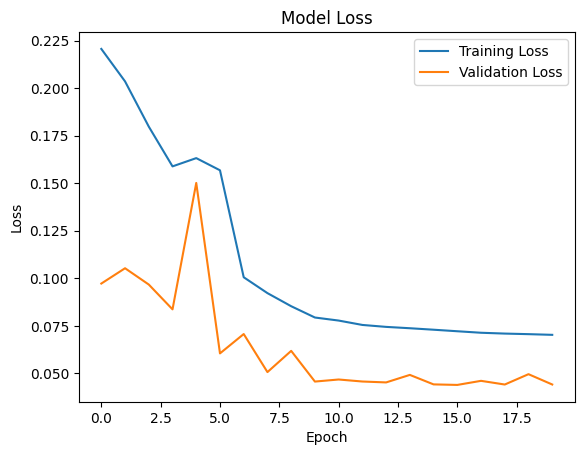

In [125]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Detect anomalies in test data

In [126]:
def detect_anomalies(model, data, threshold):
    reconstructions = model.predict(data)
    mse = ((data - reconstructions) ** 2).mean(axis=1)
    return mse > threshold

In [127]:
background_reconstructions = model.predict(X_bg_train)
background_mse = np.mean(np.square(X_bg_train - background_reconstructions), axis=1)
threshold = np.percentile(background_mse, 95)  # 95th percentile as threshold

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [128]:
X_test_array = X_test.values
anomalies = detect_anomalies(model, X_test_array, threshold)

print(f"Detected {np.sum(anomalies)} anomalies out of {len(X_test)} test samples")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Detected 25 anomalies out of 29 test samples


### Results for Fully Connected Autoencoder

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.96      1.00      0.98        24

    accuracy                           0.97        29
   macro avg       0.98      0.90      0.93        29
weighted avg       0.97      0.97      0.96        29



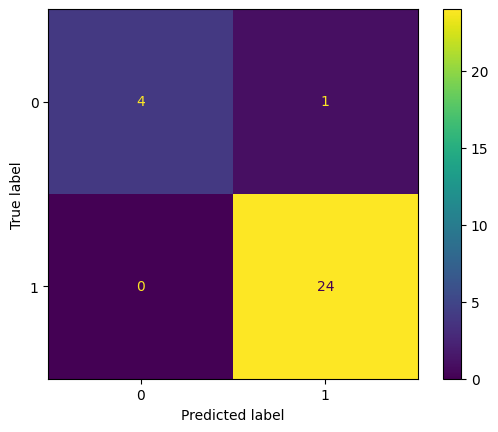

In [129]:
print(classification_report(y_test, anomalies))
disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, anomalies)).plot()

## Z-score for anomaly detection (current implementation)

In [45]:
def z_score_anomaly_detector(X_train, X_test, threshold=3):
    
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    z_scores = np.abs((X_test - mean) / std)

    # Flag as anomaly if any feature's z-score exceeds the threshold
    max_z_scores = np.max(z_scores, axis=1)
    return max_z_scores, pd.Series(np.where(max_z_scores > threshold, 1, 0))

In [46]:
import warnings
warnings.filterwarnings('ignore')

thresholds = [2,2.5, 3.5, 4, 4.5, 5, 5.5]
for threshold in thresholds:
    z_scores, y_pred = z_score_anomaly_detector(X_bg_train, X_test, threshold=threshold)
    print(f"Results with threshold {threshold}:")
    print(classification_report(y_test, y_pred))

Results with threshold 2:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.73      1.00      0.84        24

    accuracy                           0.73        33
   macro avg       0.36      0.50      0.42        33
weighted avg       0.53      0.73      0.61        33

Results with threshold 2.5:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.73      1.00      0.84        24

    accuracy                           0.73        33
   macro avg       0.36      0.50      0.42        33
weighted avg       0.53      0.73      0.61        33

Results with threshold 3.5:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.73      1.00      0.84        24

    accuracy                           0.73        33
   macro avg       0.36      0.50      0.42   

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.73      1.00      0.84        24

    accuracy                           0.73        33
   macro avg       0.36      0.50      0.42        33
weighted avg       0.53      0.73      0.61        33



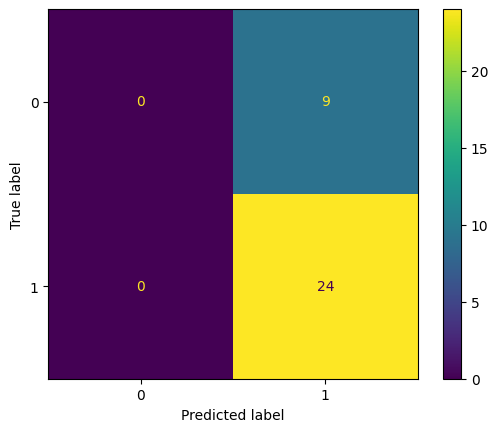

In [47]:
z_scores, y_pred = z_score_anomaly_detector(X_bg_train, X_test, threshold=2)
print(classification_report(y_test, y_pred))
disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# Isolation forest

In [110]:
from sklearn.ensemble import IsolationForest

Contamination level is basically the percent of anomalies expected.

In [111]:
iso_forest = IsolationForest()
iso_forest.fit(X_bg_train)

IsolationForest()

In [112]:
iso_forest.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [113]:
y_pred_iso = iso_forest.predict(X_test)

In [114]:
print(y_pred_iso)

[ 1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1]


In [115]:
test_iso_predictions = (y_pred_iso == -1).astype(int)

In [116]:
def evaluate_predictions(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.96      1.00      0.98        24

    accuracy                           0.97        29
   macro avg       0.98      0.90      0.93        29
weighted avg       0.97      0.97      0.96        29

Confusion Matrix:


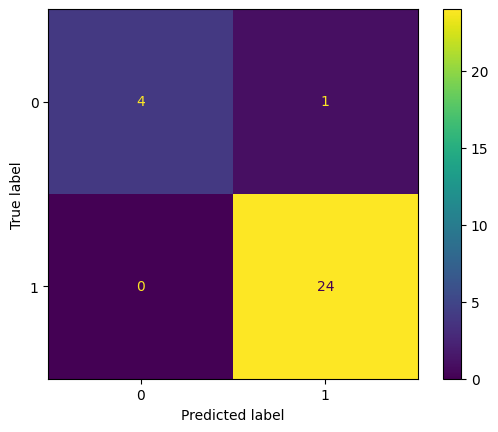

In [117]:
evaluate_predictions(y_test, test_iso_predictions)